# ML Pipeline Preparation
Follow the instructions below to help you create your ML pipeline.
### 1. Import libraries and load data from database.
- Import Python libraries
- Load dataset from database with [`read_sql_table`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_sql_table.html)
- Define feature and target variables X and Y

In [1]:
# ETL
import pandas as pd
import numpy as np
import sqlite3
import sys
import re

# NLTK
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
nltk.download(['stopwords','punkt', 'wordnet'])
nltk.download('averaged_perceptron_tagger')

# ML
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

# Multiclass
import pickle
import sklearn
from sklearn.multioutput import MultiOutputClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn import metrics

# EDA
import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/gajdulj/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/gajdulj/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/gajdulj/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/gajdulj/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [2]:
# version check
sklearn.__version__,pd.__version__

('0.22.1', '1.0.2')

In [3]:
# load data from database
conn = sqlite3.connect("data/DisasterResponse.db")
cur = conn.cursor()
sql = "select * from categorised_messages"
df = pd.read_sql(sql, conn)

df.head()

,id,message,original,genre,related,request,offer,aid_related,medical_help,medical_products,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
0,2,Weather update - a cold front from Cuba that c...,Un front froid se retrouve sur Cuba ce matin. ...,direct,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,7,Is the Hurricane over or is it not over,Cyclone nan fini osinon li pa fini,direct,1,0,0,1,0,0,...,0,0,1,0,1,0,0,0,0,0
2,8,Looking for someone but no name,"Patnm, di Maryani relem pou li banm nouvel li ...",direct,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,9,UN reports Leogane 80-90 destroyed. Only Hospi...,UN reports Leogane 80-90 destroyed. Only Hospi...,direct,1,1,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
4,12,"says: west side of Haiti, rest of the country ...",facade ouest d Haiti et le reste du pays aujou...,direct,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
# Split features and labels
features = list(df.columns[4:])
X = df['message']
Y = df[features]

print("Number of features:",len(features))
print("First three:",features[:3])

Number of features: 36
First three: ['related', 'request', 'offer']


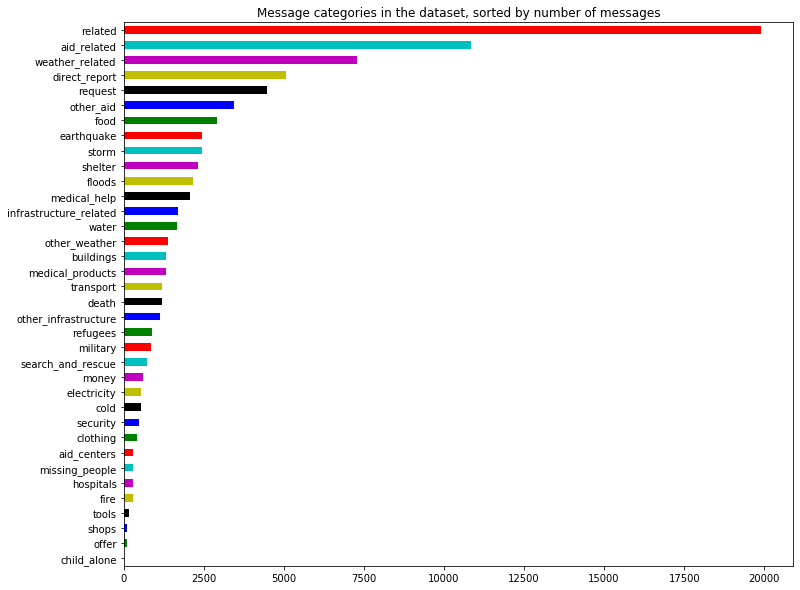

In [5]:
# Count categories
plt.figure(figsize=(12, 10))
cat_counts = Y.sum().sort_values(ascending=True)
plt.title('Message categories in the dataset, sorted by number of messages')
color = list('rgbkymc')
cat_counts.plot.barh(color=color)

### 2. Write a tokenization function to process your text data

In [6]:
def mark_urls(text):
    """ Helper function to replace urls in text with placeholders"""
    url_regex = 'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
    detected_urls = re.findall(url_regex, text)
    for url in detected_urls:
        text = text.replace(url, "urlplaceholder")
    return text

def reduce_length(text):
    """ Helper function to remove more than 2 characters of the 
    same kind occuring one after another, ex. heloooo=> heloo"""
    pattern = re.compile(r"(.)\1{2,}")
    return pattern.sub(r"\1\1", text)

def cleaner_tokenizer(text,lemmatizer = WordNetLemmatizer()):
    """Main function to clean and tokenize text"""
    url_marked = mark_urls(text)
    reduced_length = reduce_length(url_marked)
    tokens = word_tokenize(re.sub(r"[^a-zA-Z0-9]", " ", reduced_length))

    clean_tokens = []
    for tok in tokens:
        clean_tok = lemmatizer.lemmatize(tok).lower().strip()
        clean_tokens.append(clean_tok)
        
    clean_tokens = [t for t in clean_tokens if t not in set(stopwords.words('english'))]
    return clean_tokens

In [7]:
# vectorise and clean
clean_tokens = X.apply(cleaner_tokenizer)

# Transfrom to a list of all words instead of list of lists
word_list = [item for sublist in list(clean_tokens) for item in sublist]

In [8]:
# Calculate frequency distribution
fdist = nltk.FreqDist(word_list)
freq = {}

# Output top n words
for word, frequency in fdist.most_common():
    freq[word]=frequency

In [9]:
print('Top 5 words:')
{k: freq[k] for k in list(freq)[:5]}

Top 5 words:


{'water': 3037, 'people': 3004, 'food': 2895, 'help': 2638, 'need': 2481}

In [10]:
# Number of words in the dataset.
# To compare, The Oxford English Dictionary has 171,476 words.
len(freq)

31107

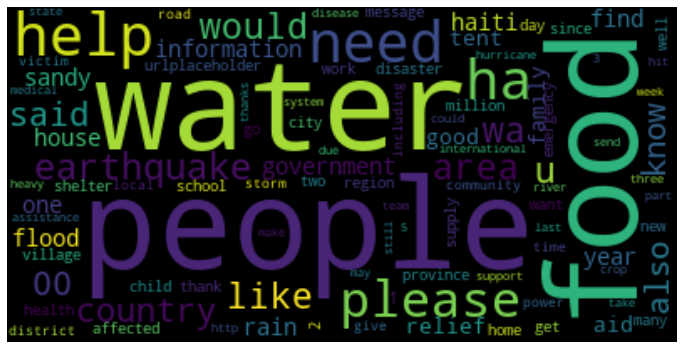

In [11]:
from wordcloud import WordCloud

wc = WordCloud(max_words=100,background_color='black').generate_from_frequencies(freq)
plt.figure(figsize=(12, 10))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.savefig('app/static/wordcloud-dark.png', bbox_inches = 'tight',
    pad_inches = 0)

### 3. Build a machine learning pipeline
This machine pipeline should take in the `message` column as input and output classification results on the other 36 categories in the dataset. You may find the [MultiOutputClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.multioutput.MultiOutputClassifier.html) helpful for predicting multiple target variables.

In [12]:
pipeline = Pipeline([
    ('vect', CountVectorizer(tokenizer=cleaner_tokenizer)),
    ('tfidf', TfidfTransformer()),
    ('clf', MultiOutputClassifier(RandomForestClassifier(n_estimators=10))),
    ])

### 4. Train pipeline
- Split data into train and test sets
- Train pipeline

In [13]:
assert len(X)==len(Y)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y,test_size=0.2)

# train classifier
pipeline.fit(X_train, Y_train)

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=<function cleaner_to...
                                                                        ccp_alpha=0.0,
                                                                        class_weight=None,
                                                                        criterion='gini',
                                                                    

In [14]:
predicted = pipeline.predict(X_test)

In [15]:
# See types of predictions and target
type(Y_test),type(predicted)

(pandas.core.frame.DataFrame, numpy.ndarray)

### 5. Test your model
Report the f1 score, precision and recall for each output category of the dataset. You can do this by iterating through the columns and calling sklearn's `classification_report` on each.

In [16]:
"""
To map predictions to actual values:

Pred: Select column n of numpy array:
[row[n] for row in predicted]

Select column n of pd dataframe: 
Y_test.iloc[:, n]

n=0
assert len(Y_test.iloc[:, n] == len([row[n] for row in predicted])
"""

def eval_model(predicted,Y_test,verbose=True):
    """Function to evaluate the performance of multiclass model.

    Args:
        predicted: Model predictions
        
        Y_test: True values that are to be predicted
        
        verbose: if True: see the performance across each of the categories
        if False: show only a weighted F1 score.
    """
    f1_scores = []
    for index, col in enumerate(Y_test.columns):
        if verbose:
            print(classification_report(Y_test.iloc[:, index], [row[index] for row in predicted]))
        score = f1_score(Y_test.iloc[:, index],  
            [row[index] for row in predicted],
            average='weighted')
        f1_scores.append(score)
    avg_f1 = np.mean(f1_scores)
    print(f'Avg weighted f1-score:{round(avg_f1,3)}')

In [17]:
eval_model(predicted,Y_test)

Avg weighted f1-score:0.932


In [18]:
#See parameters in the pipeline
pipeline.get_params()

{'memory': None,
 'steps': [('vect',
   CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                   dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                   lowercase=True, max_df=1.0, max_features=None, min_df=1,
                   ngram_range=(1, 1), preprocessor=None, stop_words=None,
                   strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                   tokenizer=<function cleaner_tokenizer at 0x1a2790e710>,
                   vocabulary=None)),
  ('tfidf',
   TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True)),
  ('clf',
   MultiOutputClassifier(estimator=RandomForestClassifier(bootstrap=True,
                                                          ccp_alpha=0.0,
                                                          class_weight=None,
                                                          criterion='gini',
                                                          max_d

### 6. Improve your model
Use grid search to find better parameters. 

In [30]:
# Check the model performance on less vocabulary features
parameters = {
    'clf__estimator__n_estimators': [100, 200]
}

In [31]:
cv = GridSearchCV(estimator=pipeline, param_grid=parameters, 
                  scoring='f1_weighted', cv=3, n_jobs=-1,verbose=10)

cv.fit(X_train, Y_train)

Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   6 | elapsed:  5.2min remaining: 10.4min
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:  5.2min remaining:  5.2min
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:  5.3min remaining:  2.6min
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:  8.0min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:  8.0min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('vect',
                                        CountVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.int64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                                        prep

In [32]:
cv.best_params_

{'vect__max_features': 3000}

### 7. Test your model
Show the accuracy, precision, and recall of the tuned model.  

Since this project focuses on code quality, process, and  pipelines, there is no minimum performance metric needed to pass. However, make sure to fine tune your models for accuracy, precision and recall to make your project stand out - especially for your portfolio!

In [33]:
# Reducing the number of features did not impact the performance of the model.
cv.predict(X_test)
eval_model(predicted,Y_test)

Avg weighted f1-score:0.938


### 8. Try improving your model further. Here are a few ideas:
* try other machine learning algorithms
* add other features besides the TF-IDF

In [34]:
# Adding more features derrived by custom tranformers.

class Text_Length(BaseEstimator, TransformerMixin):
    """A class that gets a text length from text"""
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_tagged = pd.Series(X).apply(lambda x: len(x)).values
        return pd.DataFrame(X_tagged)
    
class Text_Sentiment(BaseEstimator, TransformerMixin):
    """A class that gets a text sentiment from text.
    Ended up not using it due to long fitting time"""
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        analyser = SentimentIntensityAnalyzer()
        
        return pd.Series(X).apply(lambda x: analyser.polarity_scores(X)['compound']).values

class StartingVerbExtractor(BaseEstimator, TransformerMixin):
    """ A class that uses sentence tokens and parts of speach tagger to extract if the first
    is a verb in base or present form. The other forms should be handled by lemmatizer.
    
        target tags:
            VB (verb), base form, ex. help
            VBP (verb), sing. present, ex.help
    """
    def starting_verb(self, text):
        sentence_list = nltk.sent_tokenize(text)
        for sentence in sentence_list:
            pos_tags = nltk.pos_tag(cleaner_tokenizer(sentence))
            try:
                first_word, first_tag = pos_tags[0]
                if first_tag in ['VB', 'VBP']:
                    return 1
                else:
                    return 0
            except: return 0
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_tagged = pd.Series(X).apply(lambda x: self.starting_verb(x)).fillna(0).values
        return pd.DataFrame(X_tagged)

In [35]:
def model_pipeline():
    pipeline = Pipeline([
        ('features', FeatureUnion([
            ('text_pipeline', Pipeline([
                ('vect', CountVectorizer(tokenizer=cleaner_tokenizer,max_features=3000)),
                ('tfidf', TfidfTransformer())
            ])),
            ('startverb', StartingVerbExtractor())
            ])),

        ('clf', MultiOutputClassifier(AdaBoostClassifier()))
])
    return pipeline

In [36]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y,test_size=0.2)
model = model_pipeline()
model.fit(X_train, Y_train)

Pipeline(memory=None,
         steps=[('features',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('text_pipeline',
                                                 Pipeline(memory=None,
                                                          steps=[('vect',
                                                                  CountVectorizer(analyzer='word',
                                                                                  binary=False,
                                                                                  decode_error='strict',
                                                                                  dtype=<class 'numpy.int64'>,
                                                                                  encoding='utf-8',
                                                                                  input='content',
                                                                                  low

In [37]:
predicted = model.predict(X_test)

In [38]:
eval_model(predicted,Y_test)

Avg weighted f1-score:0.939


In [39]:
# As we can see, custom features did not change the model performance significantly.
# To further improve the model, I recommend more data cleaning and applying W2V models.

### 10. Use this notebook to complete `train.py`
Use the template file attached in the Resources folder to write a script that runs the steps above to create a database and export a model based on a new dataset specified by the user.